purpose of this notebook
baby steps for Quality Control pipeline
plot the folling
* physio
* motion covariate spikes
* TTL triggers
* 

In [31]:
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import neurokit2 as nk
import os


### plot raw EDA signal

802296

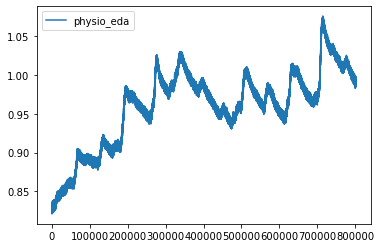

In [5]:
# physio: load physio tsv
pname = '/Users/h/Dropbox (Dartmouth College)/projects_dropbox/social_influence_analysis/scripts/physio/spacetop_fmriprep/sub-0061/ses-01/sub-0061_ses-01_task-cue_run-01-pain_recording-ppg-eda-trigger_physio.tsv'
physio = pd.read_csv(pname, sep = '\t')
samplingrate = 2000
physio.plot(y = "physio_eda")
len(physio)

In [94]:
#extract meta datta from physio filename
pname = '/Users/h/Dropbox (Dartmouth College)/projects_dropbox/social_influence_analysis/scripts/physio/spacetop_fmriprep/sub-0061/ses-01/sub-0061_ses-01_task-cue_run-01-pain_recording-ppg-eda-trigger_physio.tsv'
fname = os.path.basename(pname)

sub_num = int([match for match in fname.split('_') if "sub" in match][0].split('-')[1])
ses_num = int([match for match in fname.split('_') if "ses" in match][0].split('-')[1])
run_num = int([match for match in fname.split('_') if "run" in match][0].split('-')[1])
runtype = [k for k in ['pain', 'cognitive', 'vicarious'] if k in fname][0]
sub = f"sub-{sub_num:04d}"
ses = f"ses-{ses_num:02d}"
run = f"run-{run_num:02d}"

In [3]:
physio.columns

Index(['physio_eda', 'physio_ppg', 'trigger_mri', 'trigger_heat',
       'event_experimentduration', 'event_fixation', 'event_cue',
       'event_expectrating', 'event_stimuli', 'event_actualrating'],
      dtype='object')

In [10]:
scr_signal = nk.signal_sanitize(
    physio['physio_eda'])
scr_filters = nk.signal_filter(scr_signal,
                                sampling_rate=samplingrate,
                                highcut=1,
                                method="butterworth",
                                order=2)  # ISABEL: Detrend
scr_detrend = nk.signal_detrend(scr_filters)
physio['eda_preproc'] = scr_detrend

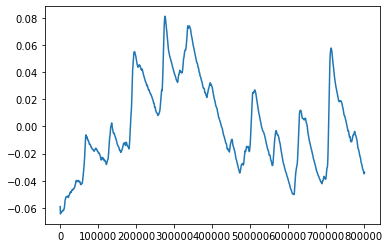

In [9]:
plt.plot(scr_detrend)

In [11]:
physio.head()

,physio_eda,physio_ppg,trigger_mri,trigger_heat,event_experimentduration,event_fixation,event_cue,event_expectrating,event_stimuli,event_actualrating,eda_preproc
0,0.833129,-0.017090,48.696899,0.277710,0.0,0.0,0.0,0.0,0.0,0.0,-0.059079
1,0.831603,-0.017700,48.687744,0.302124,0.0,0.0,0.0,0.0,0.0,0.0,-0.059091
2,0.830077,-0.017395,0.006104,0.375366,0.0,0.0,0.0,0.0,0.0,0.0,-0.059103
3,0.830077,-0.018005,0.009155,0.354004,0.0,0.0,0.0,0.0,0.0,0.0,-0.059114
4,0.827025,-0.017395,0.012207,0.350952,0.0,0.0,0.0,0.0,0.0,0.0,-0.059126


### plot resampled EDA signal

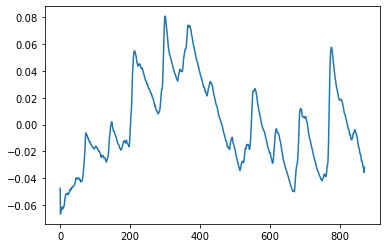

In [12]:
# %% physio: down sample method 1
x = np.arange(0,872,1)
sampling_rate = 2000
fmri_rate = 1/.46
number_of_samples = round(len(physio) * float(fmri_rate) / sampling_rate)
resampled_data = signal.resample(physio["eda_preproc"], number_of_samples)
resampled_ttl = signal.resample(physio["trigger_heat"], number_of_samples)
plt.plot(x,resampled_data, label = 'physio')

TODO: need to get rid of endpoints

In [96]:
# %% fmriprep: plot motion covariate
fname = '/Users/h/Dropbox (Dartmouth College)/projects_dropbox/social_influence_analysis/scripts/physio/spacetop_fmriprep/motion_covariates/sub-0061_ses-01_task-social_acq-mb8_run-1_desc-confounds_timeseries.tsv'
motion = pd.read_csv(fname, sep = '\t')
filter_col = []
filter_col = [col for col in motion if col.startswith('motion')]
# combine physio info to motion df
motion['physio'] = resampled_data
threshold, upper, lower = (max(resampled_ttl)-min(resampled_ttl))/2, 1, 0

motion['trigger_heat'] = np.where(resampled_ttl>threshold, upper, lower) * -1 # resampled_ttl/15 
filter_col.append('physio')
filter_col.append('trigger_heat')

filter_col

['motion_outlier00',
 'motion_outlier01',
 'motion_outlier02',
 'motion_outlier03',
 'motion_outlier04',
 'motion_outlier05',
 'motion_outlier06',
 'motion_outlier07',
 'motion_outlier08',
 'motion_outlier09',
 'physio',
 'trigger_heat']

In [52]:
# grab the indices of the motion covariates. we will plot the indexes
motion_outlier_idx= []
for col in ['motion_outlier00', 'motion_outlier01', 'motion_outlier02', 'motion_outlier03', 'motion_outlier04', 'motion_outlier05', 'motion_outlier06', 'motion_outlier07', 'motion_outlier08',
 'motion_outlier09']:
    ind = np.where(motion[col])
    motion_outlier_idx.append(ind[0][0])
ys = np.zeros(len(motion_outlier_idx))

#motion_outlier_idx: [216, 222, 265, 362, 363, 364, 424, 495, 700, 701]
#ys: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

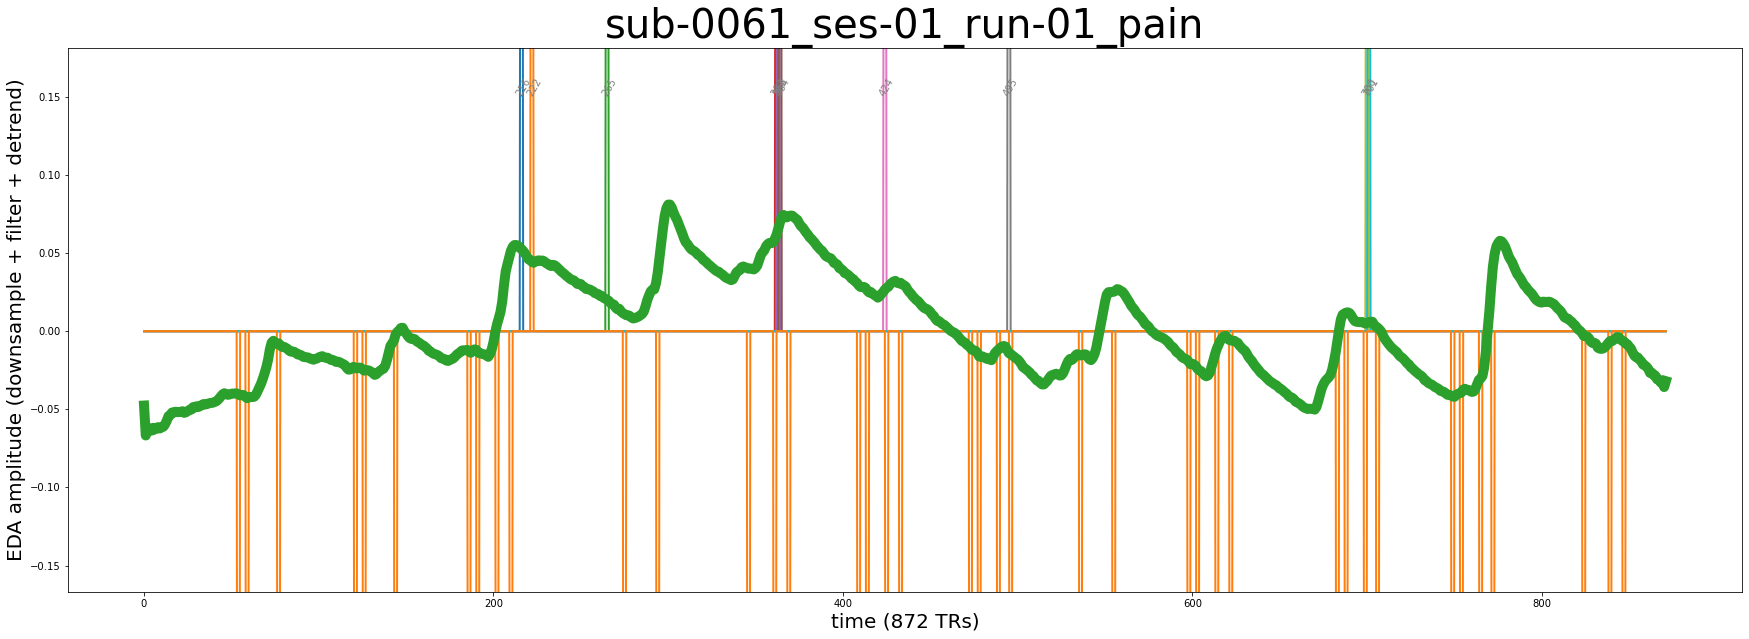

In [95]:
fig, axes = plt.subplots(ncols=1, figsize=(30, 10))
plt.ylim([min(motion['physio'])-0.1, max(motion['physio'])+0.1 ])


plt.plot(motion[filter_col], alpha=1, linewidth=2 )
plt.plot(motion['physio'], alpha=1, linewidth=10, )

# plot indices of motion covariates
for x,y in zip(motion_outlier_idx,ys):
    plt.text(x, y + .15, x,
            color = 'gray', rotation = 60,
            rotation_mode = 'anchor', fontsize = 10)
plt.xlabel('time (872 TRs)',fontsize = 20)
plt.ylabel('EDA amplitude (downsample + filter + detrend)', fontsize = 20)
plt.title(f"{sub}_{ses}_{run}_{runtype}", fontsize= 40)
plt.show()
fig.savefig('/Users/h/Downloads/motioncovariate_rawdata.png', dpi = 300)
